<a href="https://colab.research.google.com/github/arjan-hada/nuclease-design-vae/blob/main/02_protein_design_vae_nucB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative unsupervised latent variable model for protein sequences: Variational Autoencoders


Imagine this: you're at the forefront of computational biology, wielding variational autoencoders (VAEs) to not just decipher but innovate the language of proteins. Each amino acid, a letter; each sequence, a life-defining sentence. Here’s the essence:

1. **Protein Encoder**: Like a diligent scholar, VAE learns from aligned protein sequences, and distills them into multidimensional latent space. This latent space captures the essential information about the protein sequence.

2. **Latent Space**: Within this latent realm, the VAE, akin to an explorer, identifies the underlying biological patterns in existing protein sequences.

3. **Decoder**: Given a point in the latent space identified as potentially interesting (e.g., representing a stable protein), the decoder translates this point back into a new protein sequence. This creates novel sequences with a higher likelihood of possessing the desired properties.

VAE marries the predictive power of machine learning with the creative potential of synthetic biology. It has the potential to accelerate the discovery of therapeutic proteins and enzymes with enhanced catalytic properties.

## Setup

In [ ]:
!pip install seqlike biopython python-Levenshtein torcheval -q miniminiai datasets &> /dev/null

In [ ]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
!python --version

Python 3.10.12


In [ ]:
#Installing MAFFT using apt-get in quiet mode
!apt-get install -qq -y mafft &> /dev/null

In [ ]:
#Checking that MAFFT was succesfully installed
#!mafft --help

In [ ]:
# Import libraries
from seqlike import aaSeqLike
from seqlike.alphabets import AA
from Bio import SeqIO
import pandas as pd
import multiprocessing as mp
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)
import fastcore.all as fc

from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
import torch.optim as optim
from torch.optim import lr_scheduler
from miniminiai import *
from fastai.callback.training import GradientClip
from functools import partial

/usr/local/lib/python3.10/dist-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [ ]:
import random
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
torch.manual_seed(1)
set_seed(42)

In [ ]:
!mkdir -p data

## The data: Multiple Sequence Alignment

#### Train and eval sequence

In [ ]:
!wget -O data/tr-F1BV52-F1BV52-BACLI_blast_nr_5000_aligned_ungap.fasta https://raw.githubusercontent.com/arjan-hada/nuclease-design-vae/main/data/tr-F1BV52-F1BV52-BACLI_blast_nr_5000_aligned_ungap.fasta

--2024-12-03 22:25:24--  https://raw.githubusercontent.com/arjan-hada/nuclease-design-vae/main/data/tr-F1BV52-F1BV52-BACLI_blast_nr_5000_aligned_ungap.fasta
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1007916 (984K) [text/plain]
Saving to: ‘data/tr-F1BV52-F1BV52-BACLI_blast_nr_5000_aligned_ungap.fasta’

data/tr-F1BV52-F1BV 100%[===================>] 984.29K  3.71MB/s    in 0.3s    

2024-12-03 22:25:25 (3.71 MB/s) - ‘data/tr-F1BV52-F1BV52-BACLI_blast_nr_5000_aligned_ungap.fasta’ saved [1007916/1007916]



In [ ]:
!head data/tr-F1BV52-F1BV52-BACLI_blast_nr_5000_aligned_ungap.fasta

>tr|F1BV52|F1BV52_BACLI NucB OS=Bacillus licheniformis OX=1402 GN=nucB PE=1 SV=1
MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKA
GHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGA
GSWVGNRLNGYADGTRILFIVQ
>ref|WP_059231053.1| NucA/NucB deoxyribonuclease domain-containing protein [Bacillus paralicheniformis] >gb|ADX31661.1| NucB [Bacillus licheniformis] >gb|MBG9883346.1| sporulation protein [Bacillus paralicheniformis] >gb|MDE1383827.1| NucA/NucB deoxyribon
MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKA
GHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGA
GSWVGNRLNGYADGTRILFIVQ
>ref|WP_075754562.1| MULTISPECIES: NucA/NucB deoxyribonuclease domain-containing protein [Bacillus] >gb|MSO00849.1| sporulation protein [Bacillus paralicheniformis] >gb|MSO04857.1| sporulation protein [Bacillus paralicheniformis] >gb|MSO08850.1| sporulati
MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKA


In [ ]:
input_file = "data/tr-F1BV52-F1BV52-BACLI_blast_nr_5000_aligned_ungap.fasta"

In [ ]:
seqs = pd.Series([aaSeqLike(s, alphabet=AA)
for s in SeqIO.parse(input_file, "fasta")])
seqs = pd.Series([x for x in seqs if "B" not in x and "X" not in x])
len(seqs)

3357

In [ ]:
seqs[:10].seq.plot()

GridPlot(id='p1074', ...)

In [ ]:
print(seqs.seq.as_alignment().get_alignment_length())

142


We are starting from a set of meaningful protein sequences from multiple sequence alignment, and we hope to train a model to reproduce them with some novelty. Leveraging Multiple Sequence Alignments (MSAs) for generative model training offers advantages:

1. **Handling Sequence Length Variation:** MSAs effectively address the challenge of **sequences with different lengths**. Gap characters within the alignment accommodate variations, allowing the model to learn from sequences of varying sizes.

2. **Capturing Evolutionary Relationships:** MSAs go beyond simply aligning sequences. They capture the **evolutionary relationships** between a group of protein sequences. This is achieved by:

    - **Explicit Information:** MSAs explicitly capture **position-wise amino acid frequencies**. This reveals how **conserved** (important) each residue appears to be at a specific position in the protein.

    - **Implicit Information:** While not directly encoded, MSAs also implicitly capture **correlations between positions**. These correlations represent the interdependence of amino acids at different locations within the protein structure, a key aspect not captured by models that solely rely on position-wise frequencies.

By incorporating both explicit and implicit information from MSAs, generative models can learn more nuanced relationships between protein sequences and generate novel sequences that are not only structurally feasible but also potentially retain important functional features.

### Test sequence

Completely held out from training.

In [ ]:
!wget -O data/5OMT_A_ESMIF1_1_500_df.csv https://raw.githubusercontent.com/arjan-hada/nuclease-design-vae/main/data/5OMT_A_ESMIF1_1_500_df.csv

--2024-09-13 18:13:07--  https://raw.githubusercontent.com/arjan-hada/nuclease-design-vae/main/data/5OMT_A_ESMIF1_1_500_df.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90802 (89K) [text/plain]
Saving to: ‘data/5OMT_A_ESMIF1_1_500_df.csv’

data/5OMT_A_ESMIF1_ 100%[===================>]  88.67K  --.-KB/s    in 0.02s   

2024-09-13 18:13:07 (3.71 MB/s) - ‘data/5OMT_A_ESMIF1_1_500_df.csv’ saved [90802/90802]



In [ ]:
fname_sampled_seqs = "data/5OMT_A_ESMIF1_1_500_df.csv"
esmif1_seqs_df = pd.read_csv(fname_sampled_seqs)
esmif1_seqs_df.head()

,seqid,log_likelihood,sequence,num_muts
0,sampled_seq_1,-1.067197,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAAWFDAEWFFPCDRFPESCAQIRQAIALGHAAVCTLDRDGARARNREALAGIPRRPGYERHEWPFSECREGGRGSLVKYVDARDNQGAGRYLRRHLARYANGTKLLGVVK,57
1,sampled_seq_2,-1.029135,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAVAFDTTLQFPAAQFPESGQHIQDAIAEGHAAVCTLARQRAWQRRQEALAGIPQRAGYQRHEWPFSICTEGGAGSAVRYVSALDNSGMGSWLRNWLSQYADGTRIRLVVR,49
2,sampled_seq_3,-1.038908,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAGIFDATMQQPVAEFPESGKMIKQAIAEGFADVCTLDRAARKERYTQSLKGIPEKPGYDRHEWPFAYCKEGGAGSKVVYVKHDDNQGFGRWLDNHLSKFNDGTRIKQVVK,56
3,sampled_seq_4,-1.094937,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAMKYDVTWVFPRSKYPESGALIRDAIARGHAAVCTLARESQRLREDQALAGIPRRDGFERHEWPFAWCEEGGKGSFVRYVGKNDASGAGRWIDTTLAAYEDGTKVLFLVD,52
4,sampled_seq_5,-0.958626,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGACNYDAVLYTPCNTFPDACRHIKAAIAQGHAAVCTLDRAGRKRKSDQALAGIPRKPGYERHEWPFASCVEGGRGSAVTYVPTSDNQGAGAWLRQYLAGYADGTRILFVID,51


In [ ]:
seqs_test = pd.Series([aaSeqLike(s, alphabet=AA) for s in esmif1_seqs_df.sequence])
len(seqs_test)

500

In [ ]:
seqs_all = pd.concat([seqs, seqs_test], ignore_index=True)
len(seqs_all)

3857

In [ ]:
print(seqs_all.seq.as_alignment().get_alignment_length())

142


In [ ]:
#seqs_all.seq.plot(boxheight=1, use_bokeh=False, show_grouping=True)

In [ ]:
seqs_all[:10].seq.plot()

GridPlot(id='p1154', ...)

In [ ]:
seqs_all[-10:].seq.plot()

GridPlot(id='p1234', ...)

## Datasets and Dataloaders

In [ ]:
# Configuration
config = {
    'ni': 1,
    'nh1': 128,
    'nh2': 96,
    'nh3': 64,
    'nl': 64,
    'aln_len': 142,
    'alphabet_sz': 21,
    'STANDARD_AA': '-ACDEFGHIKLMNPQRSTVWY'
}

In [ ]:
from seqlike.encoders import onehot_encoder_from_alphabet
STANDARD_AA = config['STANDARD_AA']

class ProteinDataset(Dataset):
    """Creates a custom dataset to handle protein sequences represented as SeqLikes."""

    def __init__(self, seq_series):
        self.seq_series = seq_series
        self.encoder = onehot_encoder_from_alphabet(STANDARD_AA)
        self.xl = torch.tensor(seq_series.seq.to_onehot(encoder=self.encoder)).float().unsqueeze(1)
        self.yl = self.xl.clone()

    def __len__(self):
        """Returns the number of sequences in the dataset."""
        return len(self.seq_series)

    def __getitem__(self, index):
        """Returns the sequence at the specified index."""
        return self.xl[index, :], self.yl[index, :]

In [ ]:
ds= ProteinDataset(seqs_all)
print(len(ds))

3857


Notice that `class ProteinDataset(Dataset)` utilizes the input protein sequence as both the input and target during training.

In [ ]:
N = len(ds)
test_ds = Subset(ds, range(N - 500, N)) #last 500 seqs as test
remaining_ds = Subset(ds, range(N - 500))

In [ ]:
train_size = int((N - 500) * 0.9)
val_size = N - 500 - train_size

train_ds, val_ds = random_split(remaining_ds, [train_size, val_size])

bs = 128
train_dl, val_dl = get_dls(train_ds, val_ds, bs=bs)

# Turn it into dls
dls = DataLoaders(train_dl, val_dl)

In [ ]:
# Look at the data
xb, yb = next(iter(dls.train))
print(xb.shape)
print(yb.shape)
print(yb[0])

torch.Size([128, 1, 142, 21])
torch.Size([128, 1, 142, 21])
tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


## Model

Our model is a Variational Autoencoder (VAE) for protein sequence design. The VAE operates by first encoding an input protein sequence into a lower-dimensional latent representation, denoted as 'z'. This 'z' is not a single value, but rather a pair of vectors: the mean and standard deviation of a normal distribution. This approach allows the model to capture the essential features of the protein sequence in a compressed format while also accounting for the inherent variability observed in protein sequences. Subsequently, the VAE can sample from this learned distribution to generate new protein sequences. This sampling process enables the model to create novel protein sequences that share similar characteristics with the training data. For a tutorial on VAE see [this video](https://www.youtube.com/watch?v=9zKuYvjFFS8).

**Walks through different steps as I prototype the code, rather than final consolidated implementation.**

### Encoder

In [ ]:
def enc_conv(ni, nf, norm=nn.BatchNorm2d, act=nn.SiLU):
    """
    Creates a convolutional layer block for an encoder, with optional normalization and activation.

    Args:
        ni (int): Number of input channels.
        nf (int): Number of output channels.
        norm (nn.Module, optional): Normalization layer to use. Default is nn.BatchNorm2d.
        act (nn.Module, optional): Activation function to use. Default is nn.SiLU.

    Returns:
        nn.Sequential: A sequential container of the layers.
    """
    layers = nn.Sequential(nn.Conv2d(ni, nf, kernel_size=(3, 3),
                                     stride=(2, 1),
                                     padding=1,
                                     dilation=1))
    if norm: layers.append(norm(nf))
    if act : layers.append(act())
    return layers

ELU: May lead to more sparse and efficient encodings, capturing essential features while allowing some degree of negative feature representation. It could be more effective when a certain level of feature sparsity is desired or when you want to encourage a broader exploration of the feature space.

SiLU: Produces smoother and denser encodings, which might better capture complex and subtle patterns in the protein sequence. This could be particularly advantageous in tasks where the relationship between sequence elements is highly non-linear and intricate.


In [ ]:
# Example usage
out1 = enc_conv(config['ni'], config['nh1'])(xb)
print(out1.shape)
out2 = enc_conv(config['nh1'], config['nh2'])(out1)
print(out2.shape)
out3 = enc_conv(config['nh2'], config['nh3'])(out2)
print(out3.shape)
out4 = nn.Flatten()(out3)
print(out4.shape)

torch.Size([128, 128, 71, 21])
torch.Size([128, 96, 36, 21])
torch.Size([128, 64, 18, 21])
torch.Size([128, 24192])


In [ ]:
def eff_seq_len(seq_len_in, n, kernel_size, stride, padding, dilation):
    """
    Calculate the effective sequence length after n convolution operations.

    Args:
        seq_len_in (int): The initial length of the sequence before convolution.
        n (int): Number of convolution layers to be applied sequentially.
        kernel_size (int): Size of the kernel in each convolution layer.
        stride (int): Stride of the convolution.
        padding (int): Padding added to both sides of the input.
        dilation (int): Spacing between kernel elements.

    Returns:
        list: A list of effective sequence lengths after each convolution.
    """

    seq_lens = []  # Store heights after each convolution
    seq_len_curr = seq_len_in

    for _ in range(n):
        seq_len_curr = ((seq_len_curr + 2*padding - dilation*(kernel_size - 1) - 1) // stride) + 1
        seq_lens.append(seq_len_curr)

    return seq_lens

In [ ]:
# Example usage
eff_seq_lens = eff_seq_len(config['aln_len'], 3, kernel_size=3, stride=2,
                           padding=1, dilation=1)
eff_seq_lens

[71, 36, 18]

In [ ]:
def lin(ni, nf, act=nn.SiLU, bias=True):
    """
    Create a linear layer with optional activation.

    Args:
        ni (int): Number of input features.
        nf (int): Number of output features.
        act (callable, optional): Activation function to use. Default is nn.SiLU.
        bias (bool, optional): Whether to include a bias term. Default is True.

    Returns:
        nn.Sequential: A sequential container with the linear layer and (optionally) an activation.
    """
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if act : layers.append(act())
    return layers

In [ ]:
class VAEEncoder(nn.Module):

    def __init__(self, config):
        super().__init__()
        ni, nh1, nh2, nh3, nl, aln_len, alphabet_sz = (
            config['ni'], config['nh1'], config['nh2'], config['nh3'],
            config['nl'], config['aln_len'], config['alphabet_sz']
        )

        self.convs = nn.Sequential(
            enc_conv(ni, nh1),
            enc_conv(nh1, nh2),
            enc_conv(nh2, nh3),
            nn.Flatten())

        eff_seq_lens = eff_seq_len(aln_len, 3, kernel_size=3, stride=2, padding=1, dilation=1)
        encoded_sz = nh3 * eff_seq_lens[-1] * alphabet_sz

        self.fc_mu = lin(encoded_sz, nl, act=None)
        self.fc_logvar = lin(encoded_sz, nl, act=None)

    def forward(self, x):
        x = self.convs(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

When comparing **Max Pooling after Activation** versus **Stride in Convolution before Activation** for downsampling in protein sequence VAEs, the choice between these two methods has been explored in the literature, in the context of convolutional neural networks (CNNs).

**Stride in Convolution before Activation**
- **Information Preservation**: Stride in convolution is generally favored for its ability to preserve more information during the downsampling process. Unlike max pooling, which only retains the maximum value in a window and discards the rest, stride convolution considers all pixel information, albeit at a reduced resolution. This method is particularly useful when the goal is to maintain as much of the original feature information as possible, which can be crucial in tasks like protein sequence modeling where subtle features might be important.

- Reference: [Strided Convolution Instead of Max Pooling for Memory Efficiency of Convolutional Neural Networks](https://link.springer.com/chapter/10.1007/978-3-030-21005-2_23) and
[Learning strides in convolutional neural networks](https://ar5iv.labs.arxiv.org/html/2202.01653)

- **Unified Learning Process**: By incorporating downsampling directly into the convolutional layer, this method integrates feature extraction and dimensionality reduction into a single step, which can make the model simpler and more efficient. The learning process is streamlined, and the network might benefit from smoother gradients, especially in deeper networks.

- Reference: [Learning strides in convolutional neural networks](https://ar5iv.labs.arxiv.org/html/2202.01653).



In [ ]:
# Example usage
encoder = VAEEncoder(config)
mu, logvar = encoder(xb)
mu.shape, logvar.shape

(torch.Size([128, 64]), torch.Size([128, 64]))

### Decoder

In [ ]:
def decode_conv(ni, nf, scale_factor, norm=nn.BatchNorm2d, act=nn.SiLU):
    layers = [nn.Upsample(scale_factor=(scale_factor,1), mode='nearest'),
              nn.Conv2d(ni, nf, kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=1,
                        dilation=1)]

    if norm: layers.append(norm(nf))
    if act : layers.append(act())
    return nn.Sequential(*layers)

In [ ]:
# Example usage
eff_seq_lens = eff_seq_len(config['aln_len'], 3, kernel_size=3, stride=2,
                           padding=1, dilation=1)
out1 = lin(config['nl'], config['nh3'] * eff_seq_lens[-1] * config['alphabet_sz'])(mu)
print(out1.shape)
out2 = nn.Unflatten(1, (config['nh3'], eff_seq_lens[-1], config['alphabet_sz']))(out1)
print(out2.shape)
scale_factor = eff_seq_lens[-2]/eff_seq_lens[-1]
out3 = decode_conv(config['nh3'], config['nh2'], scale_factor)(out2)
print(out3.shape)
scale_factor = eff_seq_lens[-3]/eff_seq_lens[-2]
out4 = decode_conv(config['nh2'], config['nh1'], scale_factor)(out3)
print(out4.shape)
scale_factor = config['aln_len']/eff_seq_lens[-3]
out5 = decode_conv(config['nh1'], config['ni'], scale_factor, norm=None, act=None)(out4)
print(out5.shape)
out = nn.Softmax(dim=3)(out5)
print(out5.shape)

torch.Size([128, 24192])
torch.Size([128, 64, 18, 21])
torch.Size([128, 96, 36, 21])
torch.Size([128, 128, 71, 21])
torch.Size([128, 1, 142, 21])
torch.Size([128, 1, 142, 21])


In [ ]:
class VAEDecoder(nn.Module):
    """Decoder network for VAE protein sequence design."""

    def __init__(self, config):
        super().__init__()

        nh3, nh2, nh1, ni, nl, aln_len, alphabet_sz = (
            config['nh3'], config['nh2'], config['nh1'], config['ni'],
            config['nl'], config['aln_len'], config['alphabet_sz']
        )
        eff_seq_lens = eff_seq_len(aln_len, 3, kernel_size=3, stride=2, padding=1, dilation=1)
        encoded_sz = nh3 * eff_seq_lens[-1] * alphabet_sz

        self.layers = nn.Sequential(
            lin(nl, encoded_sz),
            nn.Unflatten(1, (nh3, eff_seq_lens[-1], alphabet_sz)),
            decode_conv(nh3, nh2, eff_seq_lens[-2]/eff_seq_lens[-1]),
            decode_conv(nh2, nh1, eff_seq_lens[-3]/eff_seq_lens[-2]),
            decode_conv(nh1, ni, aln_len/eff_seq_lens[-3], norm=None, act=None),
            #nn.Softmax(dim=3)
            )

    def forward(self, z):
        x = self.layers(z)
        return x

In [ ]:
decoder = VAEDecoder(config)
decoder(mu).shape

torch.Size([128, 1, 142, 21])

### Kaiming (He) initialization

In [ ]:
def init_weights(m, leaky=0.):
    """
    Initializes weights of convolutional and linear layers using Kaiming/He normalization.

    Parameters:
    - m: A module or layer of a PyTorch model.
    - leaky: The negative slope of the leaky ReLU activation applied after the layer.
             This parameter is used to adjust the Kaiming initialization accordingly.
             For regular ReLU, keep it at 0. For leaky ReLU, set it to the value of the negative slope.
    """
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        init.kaiming_normal_(m.weight, a=leaky)

Kaiming (He) initialization strategy designed to **preserve the variance of the inputs** through the layers of the network,
a property that is beneficial for maintaining effective gradient flow during training.

In [ ]:
iw = partial(init_weights, leaky=0.2)

### Variational AutoEncoder (VAE)

In [ ]:
class VAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = VAEEncoder(config)
        self.decoder = VAEDecoder(config)
        iw(self)

    def reparameterize(self, mu, logvar):
        """
        Re-parameterization trick to sample from N(mu, var), where var = exp(logvar).
        """
        std = torch.exp(0.5 * logvar) #convert logvar to std dev
        eps = torch.randn_like(std) # samples a random noise vector (eps) from a standard normal distribution that matches the shape of std
        return mu + eps * std # random noise vector is scaled by the standard deviation and then shifted by the mu

    def forward(self, x):
        """
        Forward pass through the VAE model.
        """
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

The VAE's `forward` method encodes an input protein, samples a latent representation ('z'), and decodes it back to a new protein. During training, we return both the reconstructed protein and the latent distribution's mean and standard deviation for loss calculation.

#### The Reparameterization Trick

The **reparameterization trick** is a fundamental technique in the training of Variational Autoencoders (VAEs) that enables the model to be trained efficiently using stochastic gradient descent. This trick is particularly crucial because it addresses a major challenge in training VAEs: backpropagating gradients through a stochastic process, specifically the sampling operation from the latent distribution.

### The Challenge in VAEs

In a VAE, the encoder network outputs parameters (typically the mean $\mu$ and log-variance $\log \sigma^2)$ of a proposed distribution $q(z|x)$ for the latent variables $z$ given an input $x$. During training, to generate a sample from this distribution, we would typically sample from a normal distribution parameterized by these outputs. This sampling step introduces randomness into the model, which complicates the direct application of backpropagation because the gradient of the sampling operation is not well-defined.

To overcome this, the reparameterization trick reformulates the random sampling in a way that decouples the stochasticity from the network parameters, thus allowing the gradient to be backpropagated through the deterministic part of the model.

**Steps:**
1. **Generate an auxiliary random variable $\epsilon$**: Draw $\epsilon$ from a standard normal distribution, $ \epsilon \sim \mathcal{N}(0, I)$. This step is done independently of the model parameters, so it does not interfere with the gradient computation.

2. **Reparameterize $z$**: Instead of sampling $z$ directly from $q(z|x) = \mathcal{N}(z; \mu, \sigma^2)$, we compute $z$ using the deterministic function:
   $$
   z = \mu + \sigma \odot \epsilon
   $$
   where $\sigma$ is the standard deviation derived from the encoder’s output $(\sigma = \exp(\frac{1}{2} \log \sigma^2))$, and $\odot$ denotes element-wise multiplication.

**Benefits of Reparameterization**

- **Differentiability**: This reparameterization makes the sampling process differentiable with respect to the network parameters. The randomness is isolated to $\epsilon$, and $z$ becomes a deterministic function of $\mu$, $\sigma$, and $\epsilon$. This allows the gradient of the loss with respect to the parameters $\mu$ and $\sigma$ to be computed via backpropagation.
- **Gradient Estimation**: It enables a more accurate and stable gradient estimation, as the gradients are no longer estimated directly through the stochastic sampling process but through the deterministic part (i.e., the computation involving $\mu$, $\sigma$, and $\epsilon$).

**Practical Implication**

This trick is critical for training VAEs because it allows the use of standard stochastic gradient descent (SGD) techniques by ensuring that all parts of the computational graph are differentiable. It also helps in reducing the variance of the gradient estimates, making the training process more stable and efficient.

In essence, the reparameterization trick is key to enabling efficient training of models like VAEs where part of the model involves drawing samples from a distribution whose parameters are output by the model itself.

In [ ]:
m = VAE(config)
m

VAE(
  (encoder): VAEEncoder(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 96, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (2): Sequential(
        (0): Conv2d(96, 64, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (3): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Sequential(
      (0): Linear(in_features=24192, out_features=64, bias=True)
    )
    (fc_logvar): Sequential(
      (0): Linear(in_features=24192, out_features=64, bias=True)
    )
  )
  (decoder): VAEDecoder(

In [ ]:
result = m(xb)

reconstruction, mean, logvar = result

reconstruction.shape, mean.shape, logvar.shape

(torch.Size([128, 1, 142, 21]), torch.Size([128, 64]), torch.Size([128, 64]))

## The Learner

### VAE Loss math

We have two terms in our VAE loss function. Reconstruction loss measures how well the model has reconstructed the protein from 'z', and the KL Divergence is there to force the VAE to learn a distribution that is close to a standard normal distribution. This is a regularizer that helps the model to learn meaningful representations, so that (if all goes well) we can later use it to generate new proteins.

$$
\text{VAE Loss} = \text{Reconstruction Loss} + \text{KL Divergence Loss}
$$


#### ELBO and VAE loss

The terms "ELBO" (Evidence Lower Bound) and "VAE loss" are crucial yet distinct in the context of Variational Autoencoders (VAEs). Both encompass the same components—the reconstruction error and KL divergence—but are utilized differently. The ELBO aims to maximize the bound to increase the log-likelihood of the observed data by bringing the variational posterior $q(z∣x)$ closer to the true posterior $p(z∣x)$. In contrast, the VAE loss, formulated as the negative of the ELBO, is minimized during training.

**ELBO: Evidence Lower Bound**

The ELBO is a statistical construct used in variational inference to provide a lower bound to the marginal log-likelihood $\logp(x)$ of the observed data. It is formulated to maximize the likelihood of the data while keeping the model's inferred latent distributions close to a prior distribution. The ELBO is given by:

$$
\text{ELBO} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) \| p(z))
$$

Where:
- $\mathbb{E}_{q(z|x)}[\log p(x|z)]$ is the expected log-likelihood of the observed data under the model, encouraging accurate reconstruction of the data.
- $D_{KL}(q(z|x) \| p(z))$ is the KL divergence between the variational approximation of the posterior $q(z|x)$ and the prior distribution $p(z)$, promoting regularization of the latent space.

**VAE Loss**

The VAE loss, on the other hand, is the specific formulation used in training VAE models, which typically aims to minimize a function that is, in essence, the negative of the ELBO. Thus, the VAE loss can be expressed as:

$$
\text{VAE Loss} = -\text{ELBO} = -(\mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) \| p(z)))
$$

This rephrasing leads to:

$$
\text{VAE Loss} = D_{KL}(q(z|x) \| p(z)) - \mathbb{E}_{q(z|x)}[\log p(x|z)]
$$

Where:
- The negative sign in front of the expected log-likelihood (reconstruction loss) arises from converting the maximization of ELBO into a minimization problem.
- **Reconstruction Loss** can be computed using various methods, such as mean squared error (MSE) or cross-entropy, depending on the nature of the data.

#### Kullback-Leibler (KL) divergence

The Kullback-Leibler (KL) divergence is a measure from information theory that quantifies how much one probability distribution differs from a second, reference probability distribution. It is particularly important in the context of Variational Autoencoders (VAEs) because it measures how much the distribution of the latent variables (learned by the encoder) diverges from the prior distribution (typically a standard normal distribution).

**Understanding KL Divergence in VAEs**

In VAEs, the encoder network models the latent variables $z$ as a normal distribution with parameters (mean $\mu$) and variance $ \sigma^2$) that are functions of the input $x$. This modeled distribution is denoted as $q(z|x)$. The prior distribution over the latent variables is typically chosen to be a standard normal distribution $p(z) = \mathcal{N}(0, I)$.

The KL divergence between the approximate posterior $q(z|x)$ and the prior $p(z)$ is given by the formula:

$$
D_{KL}(q \| p) = \int q(z|x) \log \frac{q(z|x)}{p(z)} \, dz
$$

When both $q(z|x)$ and $p(z)$ are normal distributions, this equation can be solved analytically, which is what happens in most implementations of VAEs.

**KL Divergence Formula for Gaussian Distributions**

For a VAE, where:

- $q(z|x) = \mathcal{N}(z; \mu, \sigma^2)$
- $p(z) = \mathcal{N}(z; 0, 1)$

The KL divergence simplifies to:

$$
D_{KL}(q \| p) = -\frac{1}{2} \sum_k \left(1 + \log \sigma_k^2 - \mu_k^2 - \sigma_k^2\right)
$$

Here’s a breakdown of each term:

- **$\log \sigma_k^2$**: This term comes from the logarithm of the variance of $q(z|x)$. Taking the log of the variance simplifies the calculations and helps with numerical stability (hence why we often work with $\log \sigma^2$ instead of $ \sigma^2$).
- **$\mu_k^2$**: This term reflects the distance of the mean of $q(z|x)$ from the mean of the prior $p(z)$. Since the prior’s mean is 0, this is just $\mu^2$.
- **$\sigma_k^2$**: This is the variance of the posterior. It shows how spread out the posterior is compared to the prior, which has a variance of 1.
- **$1$**: This constant adjusts the terms to align the calculation with the definition of KL divergence.

The negative sign and the factor of $ -\frac{1}{2}$ are due to the derivation from the formula of the entropy and cross-entropy between two Gaussian distributions.

**Intuitive Explanation**

Intuitively, the KL divergence in the context of VAEs can be thought of as a penalty on the encoder for representing the data with a distribution $q(z|x)$ that is too far from the prior $p(z) $. This penalty encourages the encoder to use all parts of the latent space in a manner consistent with how a standard normal distribution would, promoting a well-structured and regularized latent space that facilitates the generative process.

#### Cross-Entropy as Reconstruction Loss for protein sequences

Reconstruction Loss drives the decoder to accurately reconstruct the input data from compressed latent variables. It is computed based on the discrepancy between the input data and its reconstruction, typically using metrics like mean squared error (MSE) or cross-entropy, depending on the nature of the data.

In the VAE loss formula $\text{VAE Loss} = D_{KL}(q(z|x) \| p(z)) - \mathbb{E}_{q(z|x)}[\log p(x|z)]
$, maximizing $\mathbb{E}_{q(z|x)}[\log p(x|z)]$ (or minimizing its negative, as done via cross-entropy) ensures that the decoder learns to reconstruct the input data as accurately as possible from any sampled latent state. This part of the loss function pushes the decoder to improve fidelity to the actual data, enhancing the model's ability to generate realistic sequences.  This expectation $\mathbb{E}_{q(z|x)}[\log p(x|z)]$ is essentially the average, weighted by the encoder's posterior distribution $q(z∣x)$, of the logarithm of the probability that the decoder outputs the original data $x$ when given the latent variables $z$.

For protein sequences, where each position in the sequence can be one of several amino acids (the classes), the model's task at each sequence position is essentially a classification problem.

Given:
- $ P $ as the true distribution (target one-hot encoded vector).
- $ Q $ as the predicted distribution (softmax output of the model).

The cross-entropy $ H $ between the true distribution $ P $ and the predicted distribution $ Q $ for a single data point is given by:

$$
H(P, Q) = -\sum_{c=1}^C P(c) \log Q(c)
$$

Where:
- $ C $ is the number of classes (amino acids).
- $ P(c) $ is 0 or 1 in one-hot encoding, indicating whether class $ c $ is the correct classification for the given data point.
- $ Q(c) $ is the predicted probability of class $ c $, output by the model.


### VAE Loss code

In [ ]:
def kld_loss(inp, x):  # KL Divergence
    x_hat, mu, logvar = inp
    return -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

def cross_entropy_loss(inp, x):  # Reconstruction loss
    x_indices = torch.argmax(x, dim=-1).squeeze(1) # Converts to class indices and removes the singleton channel dimension
    logits_reshaped = inp[0].float().squeeze(1) ## Removes the singleton channel dimension, resulting in [bs, seq_len, alphabet_sz]
    return F.cross_entropy(logits_reshaped.view(-1, logits_reshaped.size(-1)), x_indices.view(-1),
                           reduction='mean')

def vae_loss(inp, x): return kld_loss(inp, x) + cross_entropy_loss(inp, x)

- **`x_indices`** corresponds to \( P \), the true labels, where each index represents the actual amino acid at each position in the sequence.
- **`logits_reshaped`** corresponds to \( Q \), the logits for each amino acid that are transformed into probabilities via a softmax function within the cross-entropy calculation.

In [ ]:
# Example usage
vae_loss(result, xb)

tensor(3.1940, grad_fn=<AddBackward0>)

In [ ]:
# Example usage
cross_entropy_loss(result, xb)

tensor(3.0985, grad_fn=<NllLossBackward0>)

In [ ]:
# Example usage
kld_loss(result, xb)

tensor(0.0955, grad_fn=<MulBackward0>)

In [ ]:
class FuncMetric(Mean):
    """Compute the mean of any function (`fn`) applied to inputs and targets over all updates"""
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn

    def update(self, inp, targets):
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1

In [ ]:
from collections import defaultdict, deque

class ExtendedMetricsCB(MetricsCB):
    def __init__(self, *ms, **metrics):
        super().__init__(*ms, **metrics)
        # Initialize storage for metrics' history across epochs
        self.metrics_history = defaultdict(lambda: {'train': deque(), 'eval': deque()})

    def after_epoch(self, learn):
        # Capture and store the current epoch's metrics for both training and evaluation
        phase = 'train' if learn.model.training else 'eval'
        current_metrics = {k: v.compute() for k, v in self.all_metrics.items()}
        for name, value in current_metrics.items():
            self.metrics_history[name][phase].append(value)

        # Call the original logging mechanism
        super().after_epoch(learn)

    def plot_metrics(self):
        # Plot the stored metrics history for both training and evaluation
        for metric_name, phase_data in self.metrics_history.items():
            plt.figure(figsize=(7, 4))
            for phase, values in phase_data.items():
                epochs = range(1, len(values) + 1)
                plt.plot(epochs, values, label=f'{phase} {metric_name}')
            plt.title(f'{metric_name} Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel(metric_name)
            plt.legend()
            plt.grid(True)
            plt.show()

In [ ]:
metrics = ExtendedMetricsCB(kld=FuncMetric(kld_loss),
                    cross_entropy=FuncMetric(cross_entropy_loss))

# Define the optimizer
#opt_func = partial(optim.Adam, eps=1e-5)

### Functions for training quality plots

Functions required to define `Activationstats` callback that record the mean, standard deviation, and histogram of activations of every trainable layer. This allows us to look inside our models while they're training. Think of this as quality plots from training process we can use to find ways to make our model train better.

Code from: https://github.com/fastai/minai/blob/main/core.ipynb

In [ ]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp).float()
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

In [ ]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

In [ ]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

In [ ]:
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [ ]:
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [ ]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [ ]:
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')


    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

### Learning rate finder

`Learner` class from super-duper awesome [fastai](https://github.com/fastai/course22p2/blob/master/nbs/29_vae.ipynb).

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.backends.cudnn.enabled

True

{'kld': '0.469', 'cross_entropy': '2.840', 'loss': '3.269', 'epoch': 0, 'train': 'train'}


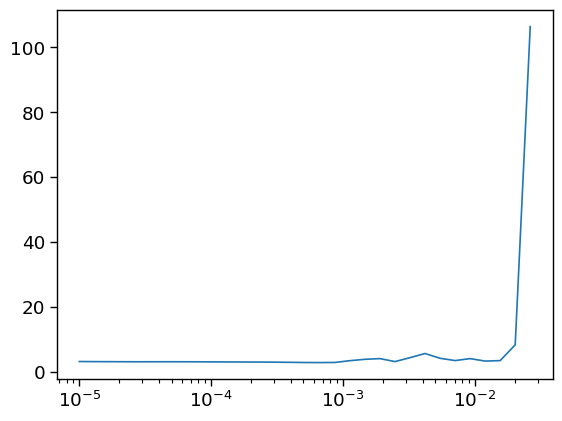

In [ ]:
lrf_cbs = [TrainCB(), DeviceCB(), metrics]
model = VAE(config)
learn = Learner(model, dls, vae_loss, lr=0.1, cbs=lrf_cbs, opt_func=optim.AdamW)
# lr_find does *not* reset model, so recreate it afterwards
learn.lr_find()

### 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

In [ ]:
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

In [ ]:
lr = 5.5e-4
epochs = 50
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
astats = ActivationStats(fc.risinstance(nn.Conv2d))


cbs = [DeviceCB(), # Handles making sure data and model are on the right device
       ProgressCB(plot=True), # Displays metrics and loss during training
       metrics, # Keep track of any relevant metrics
       BatchSchedCB(sched),
       GradientClip, # Prevents exploding gradients
       MixedPrecision(),
       rec,
       astats] # Keep track of metrics

# Define the model
model = VAE(config)
learn = Learner(model, dls, vae_loss, lr=lr, cbs=cbs, opt_func=optim.AdamW)

/usr/local/lib/python3.10/dist-packages/miniminiai/miniminiai.py:370: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()


kld,cross_entropy,loss,epoch,train
0.065,3.011,3.077,0,train
0.008,3.029,3.036,0,eval
0.133,2.754,2.890,1,train
0.121,2.649,2.775,1,eval
0.198,2.376,2.576,2,train
0.200,2.205,2.411,2,eval
0.239,2.046,2.287,3,train
0.285,1.819,2.114,3,eval
0.276,1.693,1.971,4,train
0.278,1.503,1.796,4,eval


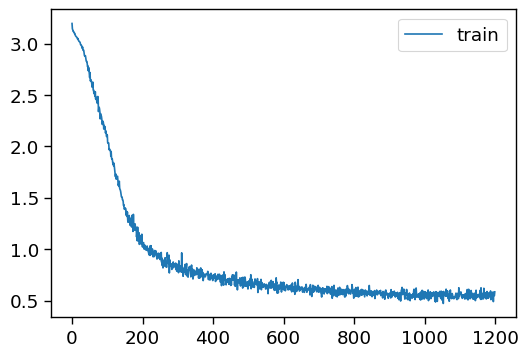

In [ ]:
learn.fit(epochs)

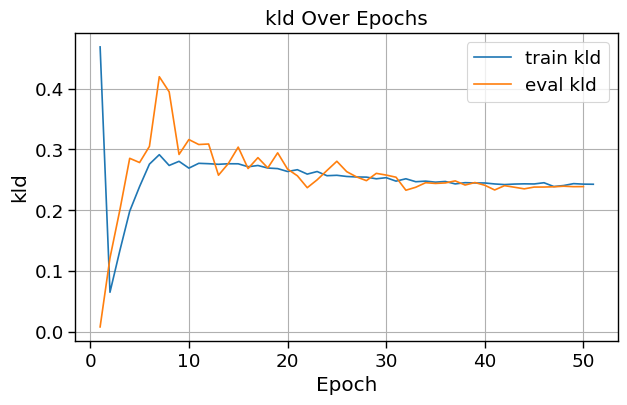

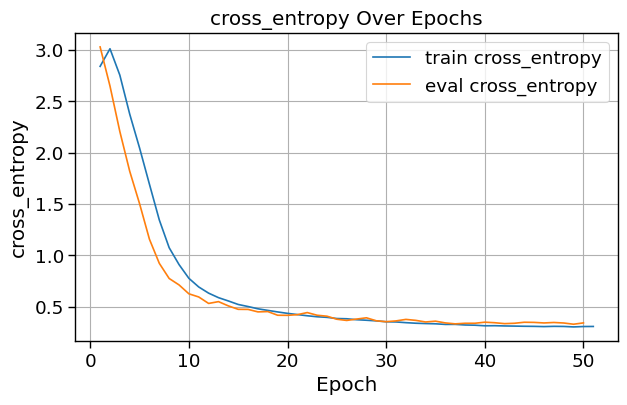

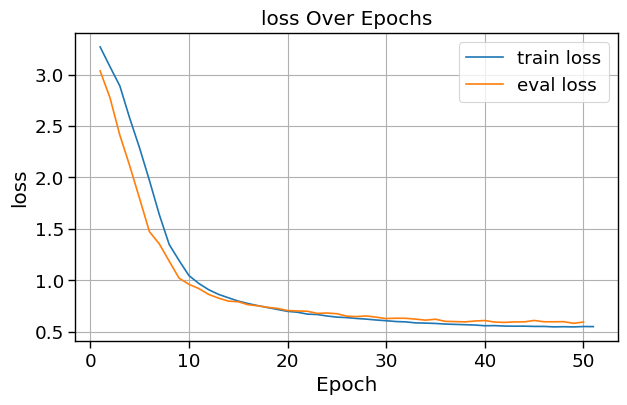

In [ ]:
metrics.plot_metrics()

View the learning rate and momentum throughout training.

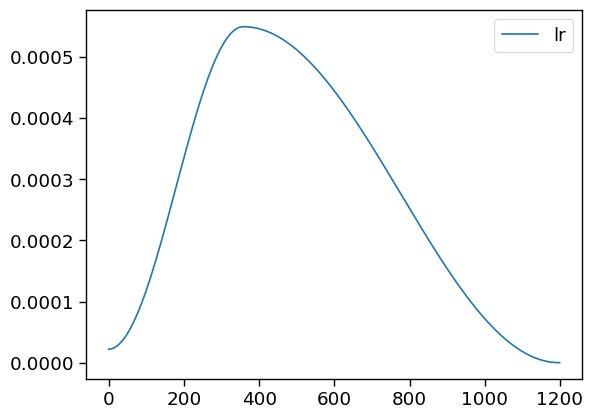

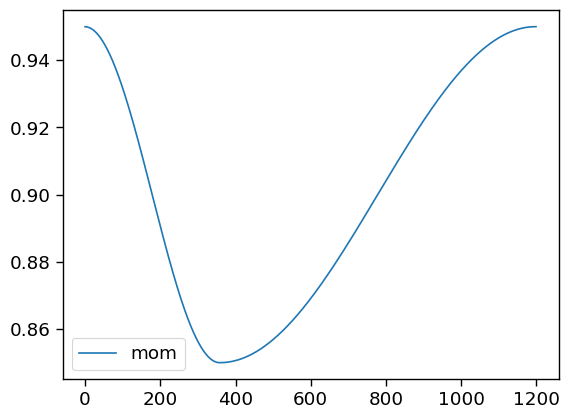

In [ ]:
rec.plot()

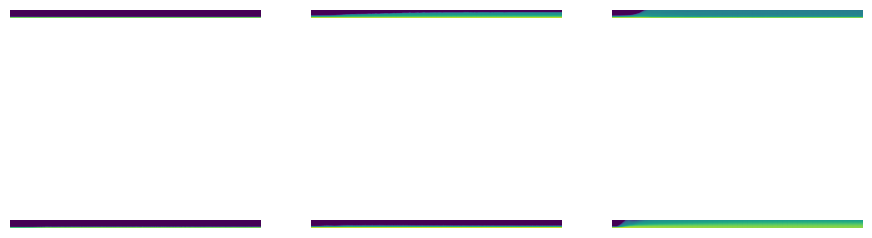

In [ ]:
plt.rc('image', cmap='viridis')
astats.color_dim()

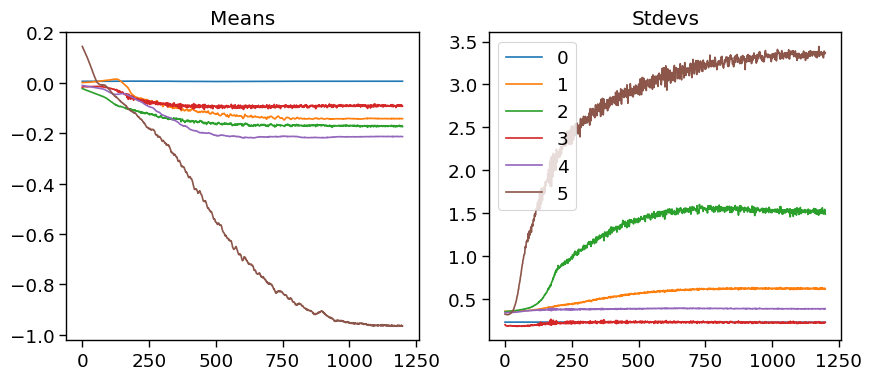

In [ ]:
astats.plot_stats()

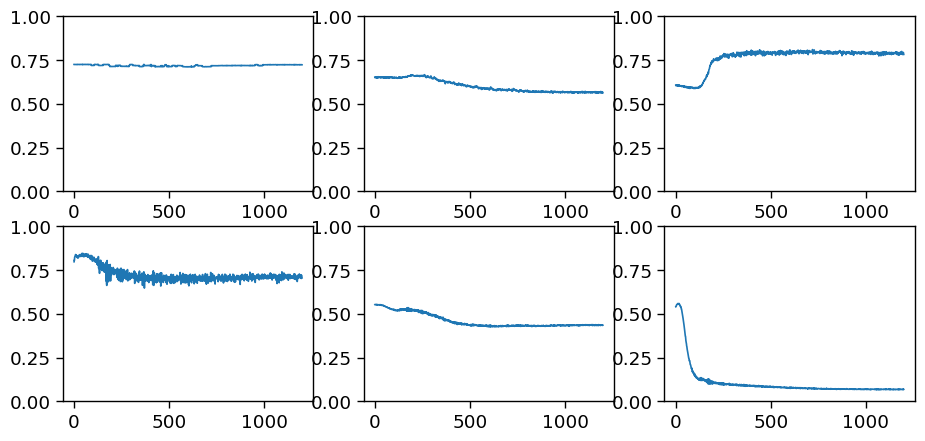

In [ ]:
astats.dead_chart()

### Save model

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [ ]:
torch.save(learn.model, mdl_path/'vae-F1BV52-nl-64.pkl')

In [ ]:
#learn.model = torch.load(mdl_path/'vae-dev.pkl', map_location=torch.device('cpu'))
learn.model = torch.load(mdl_path/'vae-F1BV52-nl-64.pkl')

<ipython-input-71-009ea4f3cb6f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learn.model = torch.load(mdl_path/'vae-F1BV52-nl-64.pkl')


By virtue of its ability to capture the diversity of existing sequences directly, generative modeling has great
potential utility for engineering proteins with improved functional properties.

In [ ]:
# Download final model from colab
!zip -r models/vae-F1BV52-nl-64.zip models/

  adding: models/ (stored 0%)
  adding: models/vae-F1BV52-nl-64.pkl (deflated 8%)


In [ ]:
# Download that zip file
from google.colab import files
files.download("models/vae-F1BV52-nl-64.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference

### Load model

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [ ]:
!unzip -q models/vae-F1BV52-nl-64.zip

In [ ]:
model = torch.load(mdl_path/'vae-F1BV52-nl-64.pkl', map_location=torch.device('cpu'))
model.eval()

<ipython-input-46-161801858deb>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(mdl_path/'vae-F1BV52-nl-64.pkl', map_location=torch.device('cpu'))


VAE(
  (encoder): VAEEncoder(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 96, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (2): Sequential(
        (0): Conv2d(96, 64, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (3): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Sequential(
      (0): Linear(in_features=24192, out_features=64, bias=True)
    )
    (fc_logvar): Sequential(
      (0): Linear(in_features=24192, out_features=64, bias=True)
    )
  )
  (decoder): VAEDecoder(

### VAE Reconstructions - Stochastic

#### Reconstruction of query sequence

In [ ]:
# query sequence - F1BV52
ref_seq = seqs_all[0].ungap().to_str()

In [ ]:
# query sequence tensor
ref = ProteinDataset(seqs_all.iloc[0:1])
ref_tensor, _ = ref[0]
ref_tensor = ref_tensor.unsqueeze(0)
ref_tensor.shape

torch.Size([1, 1, 142, 21])

In [ ]:
def forward_pass(model, xb):
    """
    Perform forward pass through model without computing gradients,
    retrieve the model's outputs.
    """
    model.eval()
    device = next(model.parameters()).device  # Auto-detects the device from model
    xb = xb.to(device) # ([bs,nc,l,w])

    # perform forward pass through model without computing gradients,
    # retrieve the model's outputs
    with torch.no_grad():
        recon_logits, _, _ = model(xb)

    # Convert logits to probabilities
    recon_probs = F.softmax(recon_logits, dim=-1) # ([bs,nc,l,w])
    return recon_probs # ([bs,nc,l,w])

In [ ]:
# reconstruction of query seq
recon_probs = forward_pass(model, ref_tensor)
recon_probs.shape

torch.Size([1, 1, 142, 21])

In [ ]:
def plot_seq_recon(original_tensor, reconstructed_tensor):
    """
    Plots a comparison between an original sequence tensor and its VAE reconstruction.

    Args:
        original_tensor (torch.Tensor): The original sequence tensor.
        reconstructed_tensor (torch.Tensor): The reconstructed sequence tensor.
    """
    plt.figure(figsize=(14, 10))

    # Plot original sequence
    plt.subplot(2, 1, 1)
    plt.imshow(original_tensor.cpu().squeeze().T, vmax=1, vmin=0, cmap='viridis')
    plt.axis("tight")
    plt.ylabel("AA Index")
    plt.xlabel("Alignment Position")
    plt.title("Original in one-hot format")

    # Plot reconstructed sequence
    plt.subplot(2, 1, 2)
    plt.imshow(reconstructed_tensor.cpu().squeeze().T, vmax=1, vmin=0, cmap='viridis')
    plt.axis("tight")
    plt.ylabel("AA Index")
    plt.xlabel("Alignment Position")
    plt.title("VAE reconstruction in one-hot format")

    plt.tight_layout()
    plt.show()

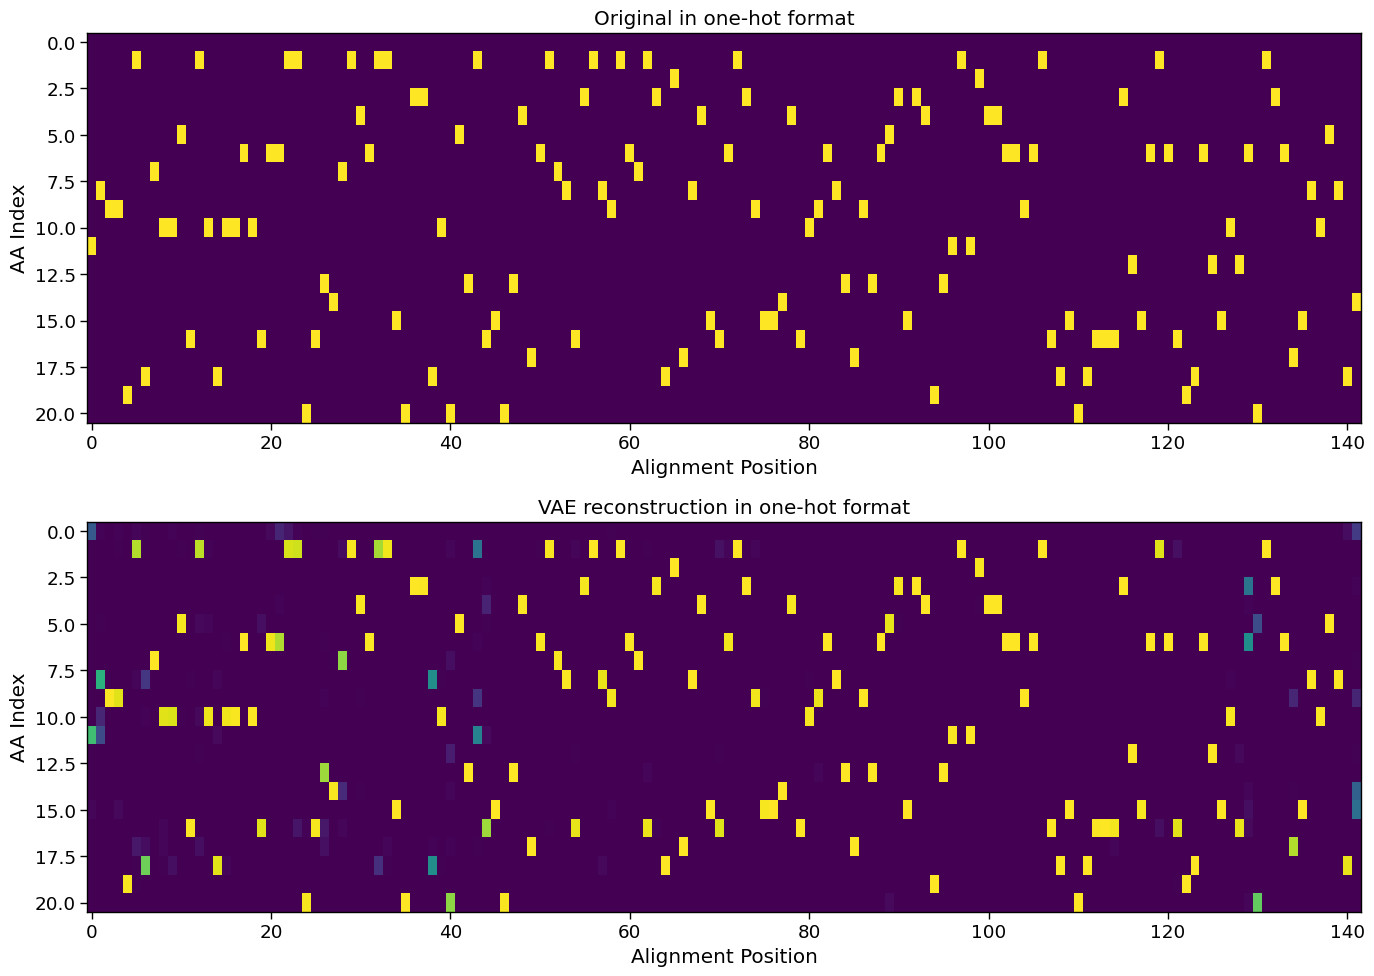

In [ ]:
plot_seq_recon(ref_tensor, recon_probs)

In [ ]:
def probs_to_seq(probs, alphabet=STANDARD_AA):
    """
    Convert tensors representing probabilities to amino acid sequences using the specified alphabet.

    Args:
        probs (torch.Tensor): Tensor of shape [bs, n_channels, seq_length, n_alphabets]
        alphabet (str): String of characters representing the amino acid alphabet.

    Returns:
        A Pandas Series of sequence strings.
    """
    return pd.Series([aaSeqLike(probs[i].cpu().numpy().squeeze(),
                               alphabet) for i in range(probs.shape[0])])

In [ ]:
ref_seq = probs_to_seq(ref_tensor)
ref_recon_seq = probs_to_seq(recon_probs)
pd.concat([ref_seq, ref_recon_seq]).seq.plot()

GridPlot(id='p1314', ...)

In [ ]:
def calc_seq_recovery(in_seqs, out_seqs):
    scores = []
    for in_seq, out_seq in zip(in_seqs, out_seqs):
        recovery = np.mean([(a==b) for a, b in zip(in_seq, out_seq)])
        scores.append(recovery)
    return scores

In [ ]:
# Calculate the sequence recovery of query sequence
calc_seq_recovery(ref_seq, ref_recon_seq)

[0.9647887323943662]

In [ ]:
import Levenshtein
def calc_num_muts(in_seqs, out_seqs):
    return [Levenshtein.distance(in_seq.seq, out_seq.seq) for in_seq, out_seq in zip(in_seqs, out_seqs)]

In [ ]:
calc_num_muts(ref_seq, ref_recon_seq)

[5]

#### Reconstruction of a training batch

In [ ]:
recon_probs = forward_pass(model, xb)
recon_probs.shape

torch.Size([128, 1, 142, 21])

In [ ]:
in_seqs = probs_to_seq(xb)
out_seqs = probs_to_seq(recon_probs)

In [ ]:
pd.concat([in_seqs.iloc[0:1], out_seqs.iloc[0:1]]).seq.plot()

GridPlot(id='p1394', ...)

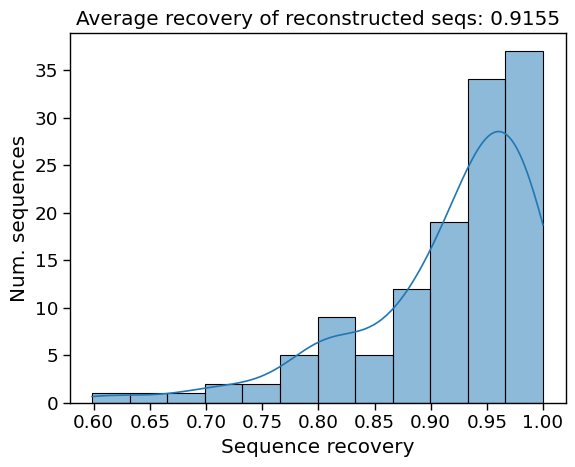

In [ ]:
# Calculate the sequence recovery of query sequence
scores = calc_seq_recovery(in_seqs, out_seqs)
sns.histplot(scores, kde=True);
plt.xlabel('Sequence recovery')
plt.ylabel('Num. sequences')
plt.title(f"Average recovery of reconstructed seqs: {np.round(np.mean(scores), 4)}");

#### Reconstruction of valid set

In [ ]:
val_xb, _ = next(iter(DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)))
val_xb.shape

torch.Size([336, 1, 142, 21])

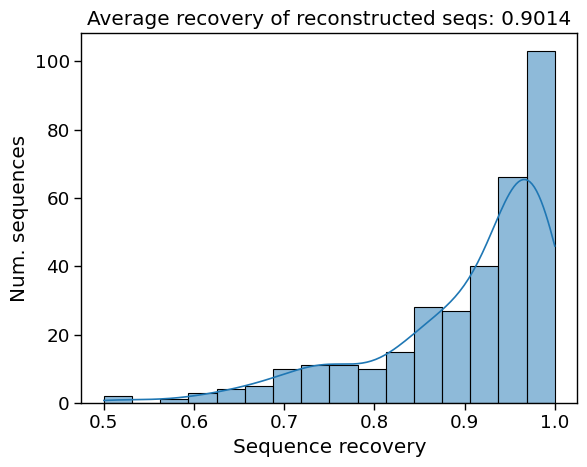

In [ ]:
recon_probs = forward_pass(model, val_xb)
in_seqs = probs_to_seq(val_xb)
out_seqs = probs_to_seq(recon_probs)

scores = calc_seq_recovery(in_seqs, out_seqs)
sns.histplot(scores, kde=True);
plt.xlabel('Sequence recovery')
plt.ylabel('Num. sequences')
plt.title(f"Average recovery of reconstructed seqs: {np.round(np.mean(scores), 4)}");

#### Reconstruction of test set

The test set is ESM-IF1 sampled sequence using [5OMT](https://www.rcsb.org/structure/5OMT) PDB as input. These are synthetic sequences not used in training or validation.

In [ ]:
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)
test_xb, _ = next(iter(test_dl))
test_xb.shape

torch.Size([500, 1, 142, 21])

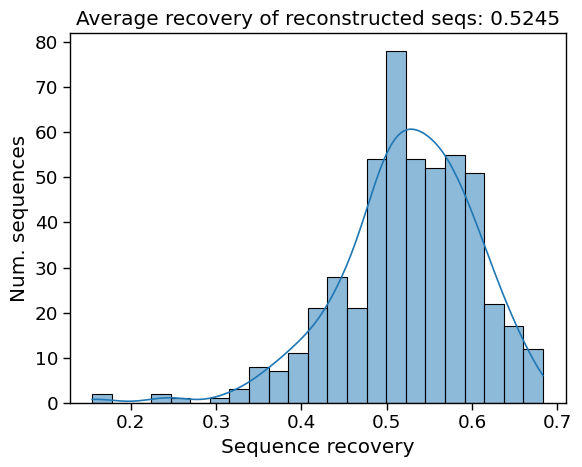

In [ ]:
recon_probs = forward_pass(model, test_xb)
in_seqs = probs_to_seq(test_xb)
out_seqs = probs_to_seq(recon_probs)

scores = calc_seq_recovery(in_seqs, out_seqs)
sns.histplot(scores, kde=True);
plt.xlabel('Sequence recovery')
plt.ylabel('Num. sequences')
plt.title(f"Average recovery of reconstructed seqs: {np.round(np.mean(scores), 4)}");

#### Sample reconstructions of query sequence

The purpose is to observe variability in sampled query sequence due to stochastic nature of VAE by repeatedly sampling.

In [ ]:
def sample_reconstructions(model, input_tensor, num_samples, alphabet=STANDARD_AA):
    """
    Sample the reconstruction of an input tensor multiple times to observe variability.

    Args:
        model (torch.nn.Module): The trained VAE model.
        input_tensor (torch.Tensor): The input tensor to reconstruct.
        num_samples (int): The number of times to sample the reconstruction.
        alphabet (str): Alphabet used for sequence conversion.

    Returns:
        pd.Series: A pandas Series containing the reconstructed sequences.
    """
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    xb = input_tensor.repeat(num_samples, 1, 1, 1)

    return pd.Series(probs_to_seq(forward_pass(model, xb)))

In [ ]:
out_seqs = sample_reconstructions(model, ref_tensor, 1000)
out_seqs[:10].seq.plot()

GridPlot(id='p1474', ...)

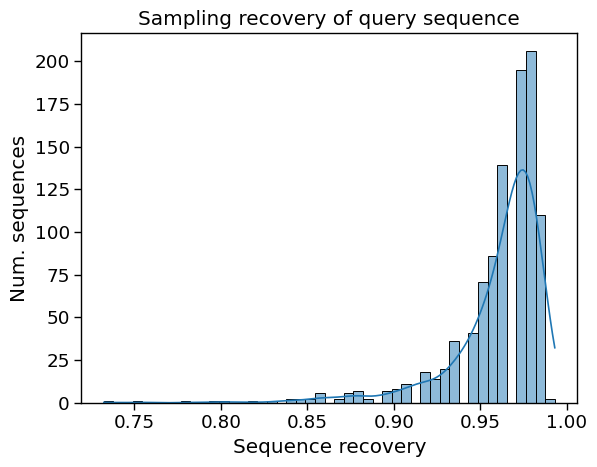

In [ ]:
in_seqs = probs_to_seq(ref_tensor.repeat(1000, 1, 1, 1))

# Calculate sequence recovery
recovery_rates = calc_seq_recovery(in_seqs, out_seqs)
sns.histplot(recovery_rates, kde=True);
plt.xlabel('Sequence recovery')
plt.ylabel('Num. sequences')
plt.title("Sampling recovery of query sequence");

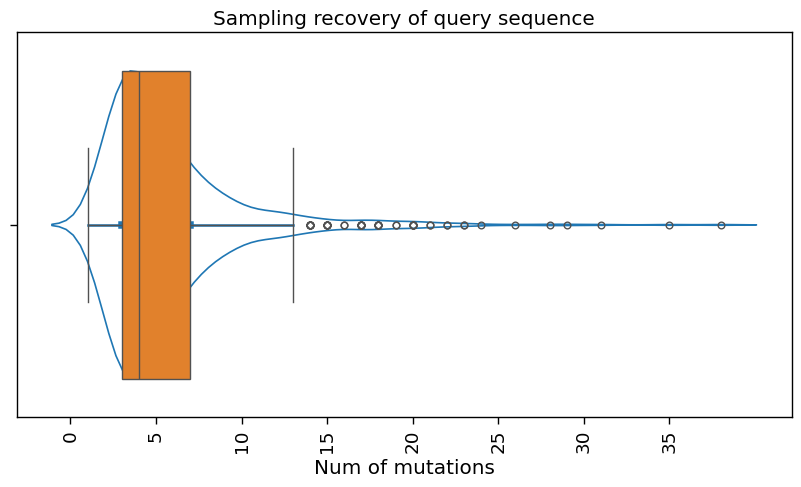

In [ ]:
# Calculate number of mutations
mutation_counts = calc_num_muts(in_seqs, out_seqs)

plt.figure(figsize=(10, 5))
sns.violinplot(x=mutation_counts, fill=False)
sns.boxplot(x=mutation_counts)
plt.xlabel('Num of mutations')
plt.title("Sampling recovery of query sequence")
ticks = np.arange(0, max(mutation_counts) + 1, 5)
plt.xticks(ticks=ticks, rotation=90);

### Local sampling - Deterministic

In [ ]:
def encode_to_latent_deterministic(model, input_tensor, scales):
    """
    Encode input tensor (single sample) to latent space and generate samples for given scales of variance,
    using a deterministic approach without introducing randomness.

    Args:
        model (torch.nn.Module): The trained VAE model.
        input_tensor (torch.Tensor): The input tensor (single sample) to reconstruct.
        scales (torch.Tensor): A tensor of scale factors for the variance.

    Returns:
        torch.Tensor: A tensor containing latent vectors sampled at specified variance scales.
    """
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)
    scales = scales.to(device)

    with torch.no_grad():
        _, mu, logvar = model(input_tensor)

    std = torch.exp(0.5 * logvar)

    # Scale std and add to mu
    z_samples = mu + scales.unsqueeze(1) * std

    return z_samples

In [ ]:
scales = torch.linspace(0.0, 2.0, steps=100)
#scales = torch.logspace(torch.log10(torch.tensor(0.01)), torch.log10(torch.tensor(2.0)), steps=50)
z_samples = encode_to_latent_deterministic(model, ref_tensor, scales)
print(z_samples.shape)

torch.Size([100, 64])


In [ ]:
def decode_latent_to_probs(model, z_samples):
    """Decode latent vectors to probabilities using the model's decoder."""
    model.eval()
    device = next(model.parameters()).device  # Auto-detects the device
    z_samples = z_samples.to(device)  # Ensure z samples are on the same device as the model

    with torch.no_grad():
        logits = model.decoder(z_samples)
        probs = F.softmax(logits, dim=-1)
    return probs

In [ ]:
in_seq = probs_to_seq(ref_tensor)
out_seqs = probs_to_seq(decode_latent_to_probs(model, z_samples))
pd.concat([in_seq, out_seqs]).seq.plot()

GridPlot(id='p1554', ...)

In [ ]:
in_seqs = probs_to_seq(ref_tensor.repeat(scales.size(0), 1, 1, 1))
mutation_counts = calc_num_muts(in_seqs, out_seqs)
print(mutation_counts)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 6, 6, 6, 7, 8, 8, 10, 13, 14, 14, 14, 16, 16, 19, 20, 23, 24, 25, 26, 31, 31, 34, 35, 38, 40, 42, 46, 50, 53, 54, 56, 58, 61, 64, 65, 66, 68, 68, 71, 74, 74, 75, 75, 78]


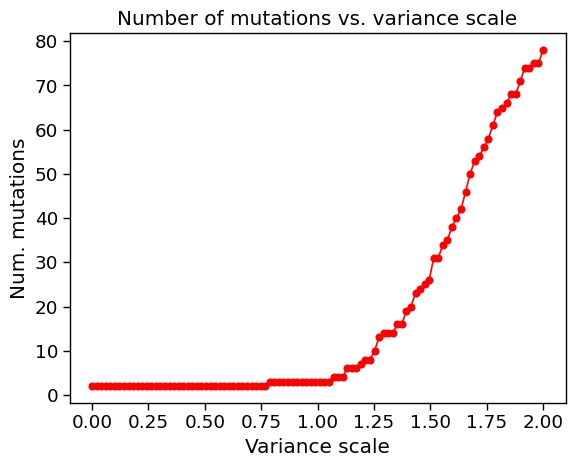

In [ ]:
plt.plot(scales, mutation_counts, "ro-")
plt.ylabel("Num. mutations")
plt.xlabel("Variance scale")
plt.title("Number of mutations vs. variance scale");

The plot shows how mutation counts change across different variance scales. The expected trend, would be to see mutation counts increase as the variance scale increases, given that increasing variance should explore more diverse regions of the latent space, leading to sequences that potentially diverge more from the original.

In [ ]:
import Levenshtein
def calc_seq_edits(in_seqs, out_seqs):
    return [Levenshtein.editops(in_seq.seq, out_seq.seq) for in_seq, out_seq in zip(in_seqs, out_seqs)]

In [ ]:
editops = calc_seq_edits(in_seqs, out_seqs)
print(editops)

[[('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace', 128, 128)], [('replace', 62, 62), ('replace',

### Local sampling - Stochastic

In [ ]:
def encode_to_latent_stochastic(model, input_tensor, scales, num_samples=1):
    """
    Generate stochastic samples for each scale of variance for a single sample input,
    using the same random perturbation across scales to isolate the effect of scaling the variance.

    Args:
        model (torch.nn.Module): The trained VAE model.
        input_tensor (torch.Tensor): The input tensor (single sample).
        scales (torch.Tensor): Scales to apply to the variance.
        num_samples (int): Number of samples per scale.

    Returns:
        torch.Tensor: Samples from the latent space, reshaped to [num_samples * num_scales, latent_dim]
    """
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)
    scales = scales.to(device)

    with torch.no_grad():
        mu, logvar = model.encoder(input_tensor)

    std = torch.exp(0.5 * logvar)

    # Expand mu and std to match the number of samples
    mu_expanded = mu.repeat(num_samples, 1)  # [num_samples, latent_dim]
    std_expanded = std.repeat(num_samples, 1)  # [num_samples, latent_dim]

    # Generate random epsilon for each sample
    eps = torch.randn(num_samples, mu.size(1), device=device)  # [num_samples, latent_dim]

    # Prepare scales and apply them to std
    scales_expanded = scales.view(-1, 1).expand(-1, mu.size(1))  # [num_scales, latent_dim]

    # Compute z for each scale and each sample
    z_samples = mu_expanded.unsqueeze(0) + scales_expanded.unsqueeze(1) * std_expanded.unsqueeze(0) * eps.unsqueeze(0)
    # [num_scales, num_samples, latent_dim]

    # Flatten the samples to get a single dimension for all samples and scales
    z_samples = z_samples.view(-1, mu.size(1))  # [num_scales * num_samples, latent_dim]

    return z_samples


In [ ]:
scales = torch.linspace(0.0, 2.0, steps=100)
z_samples = encode_to_latent_stochastic(model, ref_tensor, scales, num_samples=20)
print(z_samples.shape)

torch.Size([2000, 64])


In [ ]:
in_seq = probs_to_seq(ref_tensor)
out_seqs = probs_to_seq(decode_latent_to_probs(model, z_samples))
pd.concat([in_seq, out_seqs[:10]]).seq.plot()

GridPlot(id='p1634', ...)

In [ ]:
num_samples=20
in_seqs = probs_to_seq(ref_tensor.repeat(scales.size(0)*num_samples, 1, 1, 1))
mutation_counts = calc_num_muts(in_seqs, out_seqs)
print(mutation_counts)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

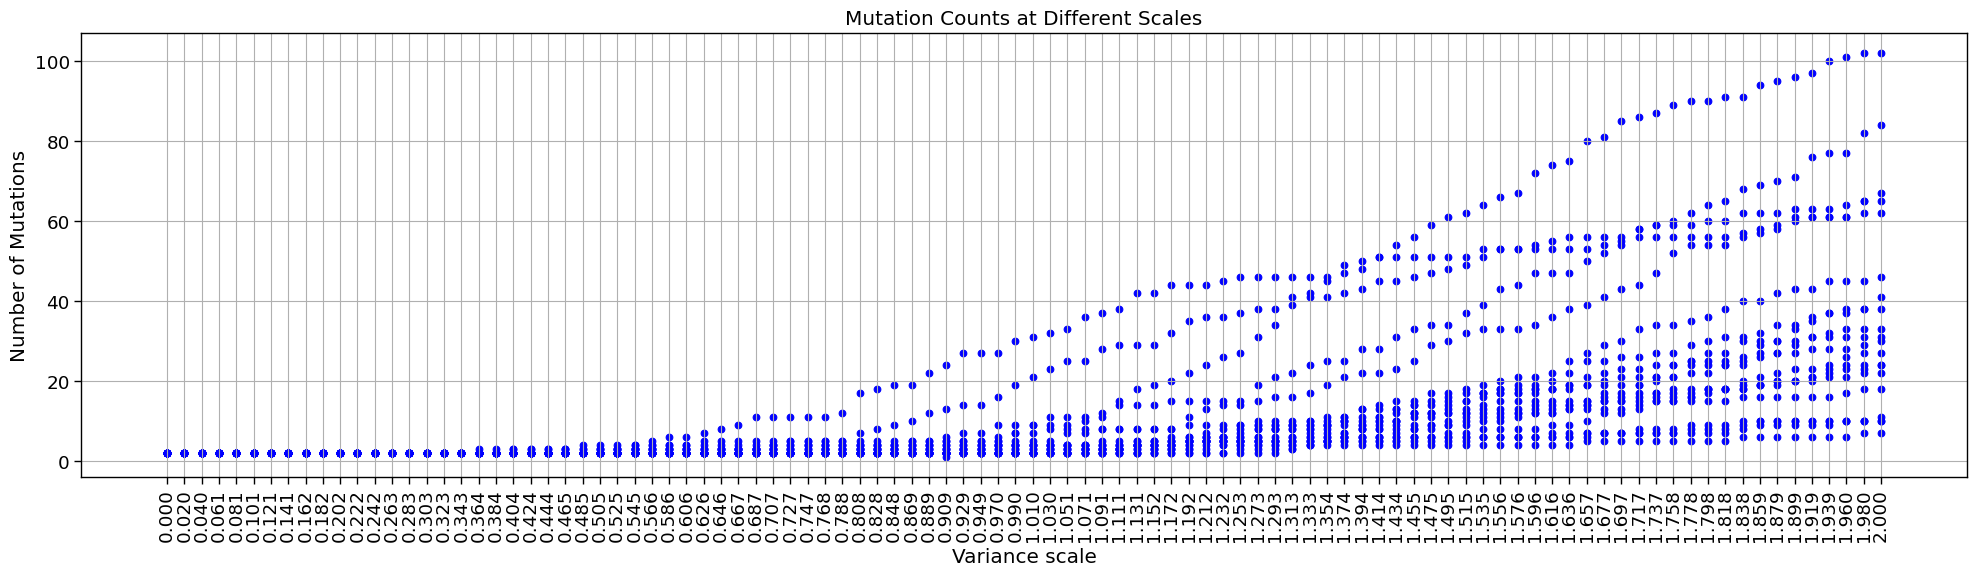

In [ ]:
# Group mutation counts by scale
mutation_counts = np.array(mutation_counts).reshape(len(scales), num_samples)

# Plotting
plt.figure(figsize=(20, 6))  # Increased figure width
for i, scale in enumerate(scales):
    plt.scatter([scale] * num_samples, mutation_counts[i], color='blue')

plt.xlabel('Variance scale')
plt.ylabel('Number of Mutations')
plt.title('Mutation Counts at Different Scales')
plt.xticks(scales, rotation=90)  # Rotate labels for better visibility
plt.grid(True)  # Adds a grid for easier reading
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

The plot shows how mutation counts change across different variance scales. The pattern suggests that mutations are minimal at lower scales and increase significantly as the variance scale increases, eventually reaching a plateau. This behavior is expected and reflects the increasing diversity in the sampled sequences from the VAE as the influence of the random component (scaled variance) becomes more significant.

#### Filter variants of reference sequence

In [ ]:
from Levenshtein import distance
df_ref_sample = pd.DataFrame(
    {
        "names": [s.id for s in out_seqs],
        "seqs": [s for s in out_seqs],
        "num_muts": [distance(s.seq, ref_seq) for s in out_seqs],
        "len": [len(s.ungap()) for s in out_seqs]
    })
df_ref_sample.head()

,names,seqs,num_muts,len
0,840d6f5c-dc4b-4944-8a88-d974ff2be667,"(M, I, K, K, W, A, V, H, L, L, F, S, A, L, V, L, L, G, L, S, G, G, A, A, Y, S, P, Q, H, A, E, G, A, A, R, Y, D, D, V, L, Y, F, P, A, S, R, Y, P, E, T, G, A, H, I, S, D, A, I, K, A, G, H, S, D, V, C, T, I, E, R, S, G, A, D, K, R, R, Q, E, S, L, K, G, I, P, T, K, P, G, F, D, R, D, E, W, P, M, A, M, C, ...)",2,142
1,92cc0b04-17b5-415f-b136-b9f4cd6ce1b8,"(M, I, K, K, W, A, V, H, L, L, F, S, A, L, V, L, L, G, L, S, G, G, A, A, Y, S, P, Q, H, A, E, G, A, A, R, Y, D, D, V, L, Y, F, P, A, S, R, Y, P, E, T, G, A, H, I, S, D, A, I, K, A, G, H, S, D, V, C, T, I, E, R, S, G, A, D, K, R, R, Q, E, S, L, K, G, I, P, T, K, P, G, F, D, R, D, E, W, P, M, A, M, C, ...)",2,142
2,1e861a3a-380e-4fca-a0f1-69070d2db407,"(M, I, K, K, W, A, V, H, L, L, F, S, A, L, V, L, L, G, L, S, G, G, A, A, Y, S, P, Q, H, A, E, G, A, A, R, Y, D, D, V, L, Y, F, P, A, S, R, Y, P, E, T, G, A, H, I, S, D, A, I, K, A, G, H, S, D, V, C, T, I, E, R, S, G, A, D, K, R, R, Q, E, S, L, K, G, I, P, T, K, P, G, F, D, R, D, E, W, P, M, A, M, C, ...)",2,142
3,6ea5a601-ef45-445c-bbaa-4d966e83e4d3,"(M, I, K, K, W, A, V, H, L, L, F, S, A, L, V, L, L, G, L, S, G, G, A, A, Y, S, P, Q, H, A, E, G, A, A, R, Y, D, D, V, L, Y, F, P, A, S, R, Y, P, E, T, G, A, H, I, S, D, A, I, K, A, G, H, S, D, V, C, T, I, E, R, S, G, A, D, K, R, R, Q, E, S, L, K, G, I, P, T, K, P, G, F, D, R, D, E, W, P, M, A, M, C, ...)",2,142
4,c017cae5-957b-4084-82a7-668192afad08,"(M, I, K, K, W, A, V, H, L, L, F, S, A, L, V, L, L, G, L, S, G, G, A, A, Y, S, P, Q, H, A, E, G, A, A, R, Y, D, D, V, L, Y, F, P, A, S, R, Y, P, E, T, G, A, H, I, S, D, A, I, K, A, G, H, S, D, V, C, T, I, E, R, S, G, A, D, K, R, R, Q, E, S, L, K, G, I, P, T, K, P, G, F, D, R, D, E, W, P, M, A, M, C, ...)",2,142


In [ ]:
df_ref_variants = df_ref_sample[(df_ref_sample['len'] == len(ref_seq)) & (df_ref_sample['num_muts'] <= round(len(ref_seq) * 0.1))].copy()
df_ref_variants['seqs_str'] = df_ref_variants['seqs'].apply(lambda x: x.ungap().to_str())
df_ref_variants = df_ref_variants.drop_duplicates(subset='seqs_str')
df_ref_variants = df_ref_variants.drop(columns=['seqs_str'])
df_ref_variants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 0 to 1961
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   names     66 non-null     object
 1   seqs      66 non-null     object
 2   num_muts  66 non-null     int64 
 3   len       66 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.6+ KB


In [ ]:
ds_ref_variants= ProteinDataset(df_ref_variants['seqs'])
dl_ref_variants = DataLoader(ds_ref_variants, batch_size=len(ds_ref_variants), shuffle=False)
xb_ref_variants, _ = next(iter(dl_ref_variants))
xb_ref_variants.shape

torch.Size([66, 1, 142, 21])

### Sequence log-likelihood

The VAE is defined by a generative model
$p_\theta(x, z)$ where z is a latent variable, x is the observed data, $p(z)$ is the prior on the latent variables (often assumed to be isotropic multivariate normal), and
$p_\theta(x|z)$ is the likelihood of the data given the latent variables parameterized by $θ$.

The marginal likelihood of the observed data is:
$z$:

$$
p_\theta(x) = \int p_\theta(x \mid z) p(z) dz
$$

However, this integral is typically intractable due to the complexity of $p_\theta(x|z)$ after training a neural network as the decoder. Instead, we approximate the true posterior $p_\theta(z|x)$ with a variational approximation
$q_\phi(z|x)$ parameterized by
$ϕ$, leading to the ELBO (Evidence Lower Bound) used for training.

#### Importance Sampling Explanation
To estimate this integral using importance sampling, we reframe it using a proposal distribution $ q_\phi(z \mid x)$ which is the encoder's output in the VAE framework:

$$
p_\theta(x) \approx \frac{1}{L} \sum_{l=1}^{L} \frac{p_\theta(x, z^{(l)})}{q_\phi(z^{(l)} \mid x)}
$$
where $ z^{(l)} $ are samples drawn from $ q_\phi(z \mid x) $.

##### Breakdown of Terms:
- **$ p_\theta(x, z^{(l)}) $** is the joint distribution under the model, which can be factored into $ p_\theta(x \mid z^{(l)}) $ (the likelihood of the data given the latent variable, provided by the decoder) and $ p(z^{(l)}) $ (the prior over the latent variables, often a standard Gaussian).
  
- **$ q_\phi(z^{(l)} \mid x) $** is the approximate posterior probability of the latent variable given the data, as modeled by the encoder.

#### Logarithmic Transformations for Stability and Computation
To stabilize the computation and to work in log-space (which prevents underflow issues with small probabilities), we take logarithms:
- **$ \log p_\theta(x \mid z^{(l)}) $**: Log probability of the data given the latent variables.
- **$ \log p(z^{(l)}) $**: Log probability of the latent variables under the model's prior.
- **$ \log q_\phi(z^{(l)} \mid x) $**: Log probability of the latent variables under the approximate posterior.

##### Formula Composition
Combining these, the weight for each sample in the importance sampling estimate is:
$$
\log \left( \frac{p_\theta(x, z^{(l)})}{q_\phi(z^{(l)} \mid x)} \right) = \log p_\theta(x, z^{(l)}) - \log q_\phi(z^{(l)} \mid x) = \log p_\theta(x \mid z^{(l)}) + \log p(z^{(l)}) - \log q_\phi(z^{(l)} \mid x)
$$

Thus:
log_weights = log_p_x_z + log_p_z - log_q_z_x
Where:
- **log_p_x_z**: Log-likelihood of the observed data given the latent variable (reconstruction log-probability).
- **log_p_z**: Log-probability of the latent variable under the prior.
- **log_q_z_x**: Log-probability of the latent variable under the approximate posterior.

This combination effectively calculates the "importance weight" for each sample, reflecting how much more or less likely the sample is under the true model as compared to the encoder's approximation. These weights then adjust the contributions of each sampled latent variable to the estimate of the marginal likelihood of the data.

##### Final log-likelihood calculation
Finally by subtracting the log of the number of samples from the log-sum-exp of the log weights, we normalize the result to find the average log-likelihood per sample, effectively estimating the integral over the latent space by averaging over the sampled estimates:
  $$
  \text{log_likelihood} = \log\left(\frac{1}{N} \sum_{i=1}^{N} e^{\text{log_weights}_i}\right)
  $$
  This is the key step where the log-likelihood of the entire data given the model is approximated by the average of the weighted likelihoods of the sampled latent variables.

In [ ]:
import torch
import torch.nn.functional as F

def importance_sampling(model, x, num_samples):
    """
    Estimates the log-likelihood of a given data point using importance sampling in a Variational Autoencoder (VAE).

    Args:
        model (torch.nn.Module): The trained VAE model.
        x (torch.Tensor): Input tensor of shape [1, 1, sequence_length, alphabet_size].
        num_samples (int): The number of latent variable samples to draw.

    Returns:
        float: The estimated log-likelihood of the input data.
    """
    model.eval()
    device = next(model.parameters()).device
    x = x.to(device)
    xb = x.repeat(num_samples, 1, 1, 1)

    # Encode the input to get the parameters of the posterior distribution
    with torch.no_grad():
        mu, logvar = model.encoder(xb)  # mu: [num_samples, latent_dim], logvar: [num_samples, latent_dim]
        std = torch.exp(0.5 * logvar) # std: [num_samples, latent_dim]
        eps = torch.randn_like(std) # eps: [num_samples, latent_dim]
        z = mu + eps * std  # z: [num_samples, latent_dim]

        # Decode the sampled latent variables
        recon_x = model.decoder(z)  # recon_x: [num_samples, 1, seq_len, alphabet_size]

        # Compute log probability of x given z (log p(x|z))
        x_labels = torch.argmax(xb, dim=-1).squeeze(1)  # x_labels: [num_samples, seq_len]
        log_p_x_z = -F.cross_entropy(recon_x.view(-1, recon_x.size(-1)), # recon_x: [num_samples * seq_len, alphabet_size]
                                        x_labels.view(-1), # x_labels: [num_samples * seq_len]
                                        reduction='none')
        # Compute log probability of x given z (log p(x|z))
        log_p_x_z = log_p_x_z.view(xb.size(0), -1).sum(1) # [num_samples, seq_len] -> [num_samples]
        # Compute log probability of z under the prior (log p(z))
        log_p_z = -0.5 * (z ** 2).sum(1)  # log_p_z: [num_samples]
        # Compute log probability of z under the posterior (log q(z|x))
        log_q_z_x = -0.5 * (logvar + (eps ** 2)).sum(1)  # log_q_z_x: [num_samples]
        # Compute log weights and estimate log-likelihood using log-sum-exp for numerical stability
        log_weights = log_p_x_z + log_p_z - log_q_z_x
        log_likelihood = torch.logsumexp(log_weights, dim=0) - torch.log(torch.tensor(num_samples, device=device))

    return log_likelihood.item()

In [ ]:
# Assuming 'model', 'x', and 'num_samples' are defined
log_likelihood = importance_sampling(model, ref_tensor, num_samples=2000)
log_likelihood

-28.255186080932617

In [ ]:
import torch
import torch.nn.functional as F

def seq_log_likelihood(model, x):
    """
    Estimates the log-likelihood of a given data point in a Variational Autoencoder (VAE).

    Args:
        model (torch.nn.Module): The trained VAE model.
        x (torch.Tensor): Input tensor of shape [bs, 1, seq_len, alphabet_size].

    Returns:
        float: The estimated log-likelihood of the input data.
    """
    model.eval()
    device = next(model.parameters()).device
    x = x.to(device)

    # Encode the input to get the parameters of the posterior distribution
    with torch.no_grad():
        mu, _ = model.encoder(x)  # mu: [bs, latent_dim]
        z = mu  # z: [bs, latent_dim]

        # Decode the sampled latent variables
        recon_x = model.decoder(z)  # recon_x: [bs, 1, seq_len, alphabet_size]

        # Compute log probability of x given z (log p(x|z))
        x_labels = torch.argmax(x, dim=-1).squeeze(1)  # x_labels: [bs, seq_len]
        log_p_x_z = -F.cross_entropy(recon_x.view(-1, recon_x.size(-1)), # recon_x: [bs * seq_len, alphabet_size]
                                     x_labels.view(-1), # x_labels: [bs * seq_len]
                                     reduction='none')  # log_p_x_z: [bs * seq_len]

    return  log_p_x_z.view(x.size(0), -1).sum(1) # [bs, seq_len] -> [bs]

In [ ]:
log_p_x_z_refseq = seq_log_likelihood(model, ref_tensor).item()
log_p_x_z_refseq

-9.862546920776367

#### log_p_x_z sampled seqs

In [ ]:
log_p_x_z_ref_vars = seq_log_likelihood(model, xb_ref_variants)

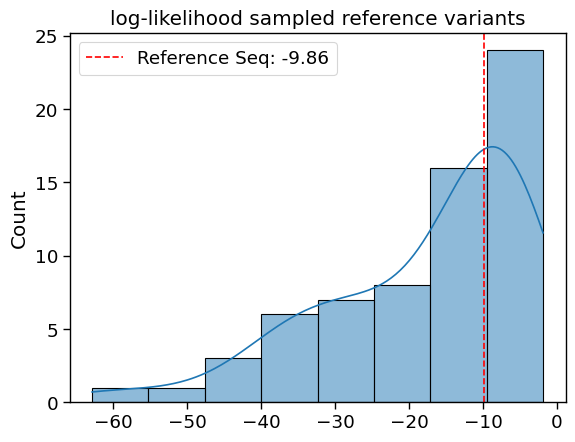

In [ ]:
sns.histplot(log_p_x_z_ref_vars.numpy(), kde=True)
plt.title("VAE log p(x|z) reference sequence variants")
# Add a vertical line for the reference sequence's log-likelihood
plt.axvline(log_p_x_z_refseq, color='red', linestyle='--', label=f'Reference Seq: {log_p_x_z_refseq:.2f}')
plt.legend()
plt.show();

In [ ]:
df_ref_variants['log_p_x_z'] = log_p_x_z_ref_vars.numpy()
df_ref_variants.head()

,names,seqs,num_muts,len,log_likelihood
0,840d6f5c-dc4b-4944-8a88-d974ff2be667,"(M, I, K, K, W, A, V, H, L, L, F, S, A, L, V, L, L, G, L, S, G, G, A, A, Y, S, P, Q, H, A, E, G, A, A, R, Y, D, D, V, L, Y, F, P, A, S, R, Y, P, E, T, G, A, H, I, S, D, A, I, K, A, G, H, S, D, V, C, T, I, E, R, S, G, A, D, K, R, R, Q, E, S, L, K, G, I, P, T, K, P, G, F, D, R, D, E, W, P, M, A, M, C, ...)",2,142,-1.902936
369,39dc7cc4-e6d9-4024-b908-a9c8a7e63277,"(M, M, K, K, W, A, V, H, L, L, F, S, A, L, V, L, L, G, L, S, G, G, A, A, Y, S, P, Q, H, A, E, G, A, A, R, Y, D, D, V, L, Y, F, P, A, S, R, Y, P, E, T, G, A, H, I, S, D, A, I, K, A, G, H, S, D, V, C, T, I, E, R, S, G, A, D, K, R, R, Q, E, S, L, K, G, I, P, T, K, P, G, F, D, R, D, E, W, P, M, A, M, C, ...)",3,142,-2.813431
415,ea35ddf0-93c7-4202-91d5-77bd48100be4,"(M, I, K, K, W, A, V, H, L, L, F, S, A, L, V, L, L, G, L, S, G, G, A, A, Y, S, P, Q, H, A, E, G, A, A, R, Y, D, D, I, L, Y, F, P, A, S, R, Y, P, E, T, G, A, H, I, S, D, A, I, K, A, G, H, S, D, V, C, T, I, E, R, S, G, A, D, K, R, R, Q, E, S, L, K, G, I, P, T, K, P, G, F, D, R, D, E, W, P, M, A, M, C, ...)",3,142,-2.676889
543,a0aabf24-80c7-4b47-99df-2ec4333990f6,"(M, M, K, K, W, A, V, H, L, L, F, S, A, L, V, L, L, G, L, S, G, G, A, A, Y, S, P, Q, H, A, E, G, A, A, R, Y, D, D, V, L, Y, F, P, A, S, R, Y, P, E, T, G, A, H, I, S, D, A, I, K, A, G, H, S, D, V, C, T, I, E, R, S, G, A, D, K, R, R, Q, E, S, L, K, G, I, P, T, K, P, G, F, D, R, D, E, W, P, M, A, M, C, ...)",4,142,-5.044529
551,75994029-9bd6-486a-83bb-95e0383958b8,"(M, I, K, K, W, A, V, H, L, L, F, S, A, L, V, L, L, G, L, S, G, G, A, A, Y, S, P, Q, H, A, E, G, A, A, R, Y, D, D, V, L, Y, F, P, A, S, R, Y, P, E, T, G, A, H, I, S, D, A, I, K, A, G, H, S, D, V, C, T, I, E, R, D, G, A, D, K, R, R, Q, E, S, L, K, G, I, P, T, K, P, G, F, D, R, D, E, W, P, M, A, M, C, ...)",3,142,-7.496969


#### log_p_x_z test set

In [ ]:
log_p_x_z_test_seqs = seq_log_likelihood(model, test_xb)

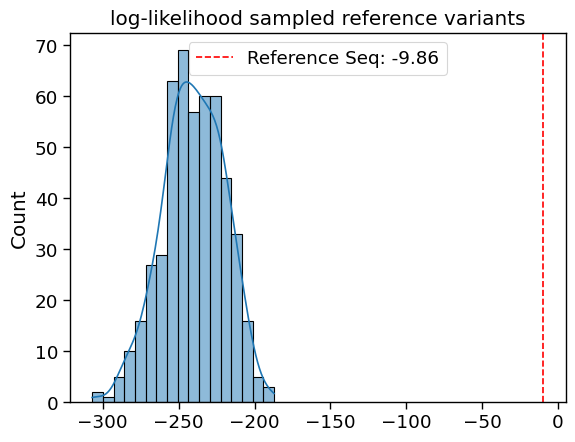

In [ ]:
sns.histplot(log_p_x_z_test_seqs.numpy(), kde=True)
plt.title("VAE log p(x|z) ESM-IF1 sequences")
# Add a vertical line for the reference sequence's log-likelihood
plt.axvline(log_p_x_z_refseq, color='red', linestyle='--', label=f'Reference Seq: {log_p_x_z_refseq:.2f}')
plt.legend()
plt.show();

In [ ]:
esmif1_seqs_df['log_likelihood_vae'] = log_p_x_z_test_seqs.numpy()
esmif1_seqs_df.head()

,seqid,log_likelihood,sequence,num_muts,log_likelihood_vae
0,sampled_seq_1,-1.067197,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAAWFDAEWFFPCDRFPESCAQIRQAIALGHAAVCTLDRDGARARNREALAGIPRRPGYERHEWPFSECREGGRGSLVKYVDARDNQGAGRYLRRHLARYANGTKLLGVVK,57,-267.930603
1,sampled_seq_2,-1.029135,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAVAFDTTLQFPAAQFPESGQHIQDAIAEGHAAVCTLARQRAWQRRQEALAGIPQRAGYQRHEWPFSICTEGGAGSAVRYVSALDNSGMGSWLRNWLSQYADGTRIRLVVR,49,-233.652817
2,sampled_seq_3,-1.038908,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAGIFDATMQQPVAEFPESGKMIKQAIAEGFADVCTLDRAARKERYTQSLKGIPEKPGYDRHEWPFAYCKEGGAGSKVVYVKHDDNQGFGRWLDNHLSKFNDGTRIKQVVK,56,-273.268738
3,sampled_seq_4,-1.094937,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAMKYDVTWVFPRSKYPESGALIRDAIARGHAAVCTLARESQRLREDQALAGIPRRDGFERHEWPFAWCEEGGKGSFVRYVGKNDASGAGRWIDTTLAAYEDGTKVLFLVD,52,-260.243958
4,sampled_seq_5,-0.958626,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGACNYDAVLYTPCNTFPDACRHIKAAIAQGHAAVCTLDRAGRKRKSDQALAGIPRKPGYERHEWPFASCVEGGRGSAVTYVPTSDNQGAGAWLRQYLAGYADGTRILFVID,51,-234.479813


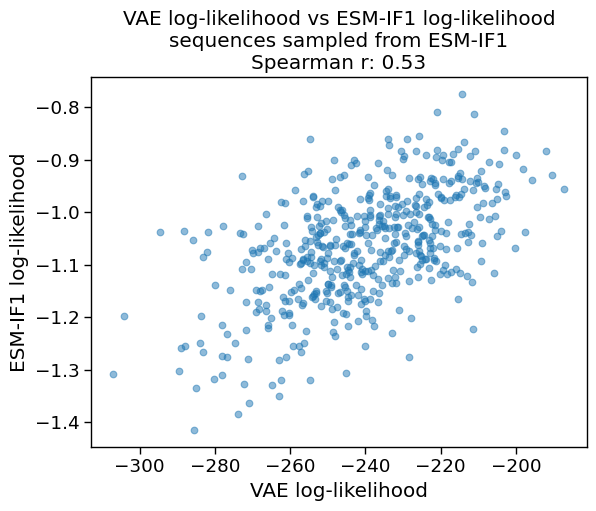

In [ ]:
from scipy.stats import spearmanr
x1 = esmif1_seqs_df.log_likelihood_vae.values
y1 = esmif1_seqs_df.log_likelihood.values
plt.scatter(x1, y1, alpha=0.5)
plt.xlabel('VAE log p(x|z)')
plt.ylabel('ESM-IF1 log-likelihood')
plt.title(f"VAE log-likelihood vs ESM-IF1 log-likelihood\nsequences sampled from ESM-IF1\nSpearman r: {spearmanr(x1, y1)[0]:.2f}")
plt.show();

#### log-likelihood using importance sampling

In [ ]:
# Example usage
ref_tensor_b = ref_tensor.repeat(20, 1, 1, 1)
ref_tensor_b.shape

torch.Size([20, 1, 142, 21])

In [ ]:
# Example usage
from tqdm import tqdm
log_likelihoods = []

# Apply importance_sampling function to each item in the batch
for i in tqdm(range(ref_tensor_b.size(0)), desc="Calculating VAE log-likelihood using importance sampling:"):
    x = test_xb[i:i+1]  # Select the i-th sample (shape: [1, 1, sequence_length, alphabet_size])
    log_likelihood = importance_sampling(model, x, 2500)
    log_likelihoods.append(log_likelihood)

log_likelihoods = torch.tensor(log_likelihoods)

Calculating VAE log-likelihood using importance sampling:: 100%|██████████| 20/20 [07:12<00:00, 21.64s/it]


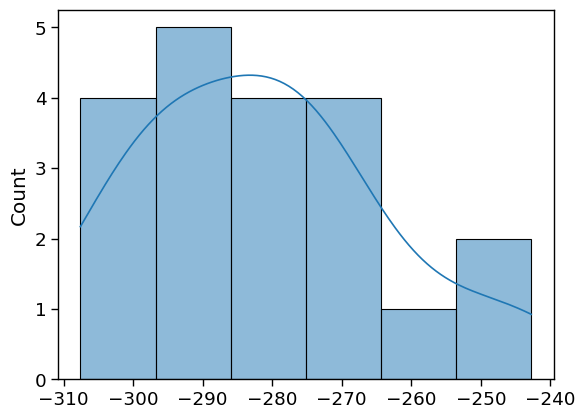

In [ ]:
sns.histplot(log_likelihoods, kde=True);